## **Set up**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.multitest import multipletests
import glob
from pathlib import Path
import os
from numpy import dtype


In [2]:
import sys
from pathlib import Path

# Get the project root 
project_root = Path.cwd().parent

# Add project root to sys.path
sys.path.append(str(project_root))

## **1. Data Overview**

## 1.1. Load data and basic info

In [3]:
from src.utils import load_data

df = load_data("2015_raw.csv", subfolder="raw")

In [4]:
print(f"Shape: {df.shape}")
print("First few rows")
df.head()

Shape: (441456, 171)
First few rows


,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,BPHIGH4,BPMEDS,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,5.0,15.0,18,10.0,1,1,2.0,1.0,1.0,1.0,...,4,2,1.0,1.0,1.0,1,1,NaN,NaN,1.0
1,3.0,88.0,88,NaN,2,1,1.0,4.0,3.0,NaN,...,2,2,3.0,3.0,4.0,2,2,NaN,NaN,2.0
2,4.0,15.0,88,88.0,1,2,2.0,1.0,3.0,NaN,...,9,9,9.0,9.0,9.0,9,9,9.0,9.0,NaN
3,5.0,30.0,30,30.0,1,2,1.0,1.0,1.0,1.0,...,4,2,1.0,1.0,1.0,1,1,NaN,NaN,9.0
4,5.0,20.0,88,30.0,1,1,2.0,1.0,3.0,NaN,...,4,2,1.0,1.0,1.0,1,1,NaN,NaN,1.0


In [23]:
def data_quality_report(df):
    report = {
        '- Total Samples': len(df),
        '- Total Features': len(df.columns),
        '- Duplicate Rows': df.duplicated().sum(),
        '- Memory Usage (MB)': df.memory_usage(deep=True).sum() / 1024**2
    }

    # Data types summary
    dtype_summary = df.dtypes.value_counts()

    return report, dtype_summary

quality_report, dtype_summary = data_quality_report(df)
print("Data Quality Report:")
for key, value in quality_report.items():
    print(f"{key}: {value}")

print("\nData Types Summary:")
print(dtype_summary)

Data Quality Report:
- Total Samples: 441456
- Total Features: 171
- Duplicate Rows: 2
- Memory Usage (MB): 641.953272819519

Data Types Summary:
float64    111
int64       57
object       3
Name: count, dtype: int64


## **2. Data Classification**

In [106]:
import pandas as pd
import numpy as np

def classify_variables_clean(df):
    numeric_vars = []
    categorical_vars = []
    boolean_vars = []

    for col in df.columns:
        if pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
            categorical_vars.append(col)
            continue

        valid_series = df[col].dropna()
        n_unique = valid_series.nunique()

        if n_unique == 2:
            boolean_vars.append(col)
            continue

        if pd.api.types.is_float_dtype(df[col]) and (valid_series % 1 != 0).any():
            numeric_vars.append(col)
            continue

        if n_unique > 50:
            numeric_vars.append(col)
        else:
            categorical_vars.append(col)

    return numeric_vars, categorical_vars, boolean_vars

numeric_cols, categorical_cols, boolean_cols = classify_variables_clean(df)

print(f"Numeric: {len(numeric_cols)} features. Example: {numeric_cols[:5]}")
print(f"Categorical: {len(categorical_cols)} features. Example: {categorical_cols[:5]}")
print(f"Boolean: {len(boolean_cols)} features. Example: {boolean_cols[:7]}")

C:\Users\pc\AppData\Local\Temp\ipykernel_7564\1446022197.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):


Numeric: 56 features. Example: ['WEIGHT2', 'HEIGHT3', 'MAXDRNKS', 'FRUITJU1', 'FRUIT1']
Categorical: 108 features. Example: ['GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'HLTHPLN1']
Boolean: 7 features. Example: ['SEX', '_MICHD', '_DRDXAR1', '_FRTRESP', '_VEGRESP', '_FRT16', '_VEG23']


## **3. Missing Values & Constant Features**

### 3.1. Checking constant features

In [107]:
# Select columns with only one unique value
single_value_cols = df.columns[df.nunique() == 1]
print(f"Number of columns with a single unique value: {len(single_value_cols)}")
print(f"Columns with a single unique value: {single_value_cols}")


Number of columns with a single unique value: 0
Columns with a single unique value: Index([], dtype='object')


### 2.2. Checking missing values

In [108]:
# Columns with missing data
missing_cols = df.columns[df.isnull().any()]

# Count missing values per column
missing_counts = df[missing_cols].isnull().sum()

# Percentage missing per column
missing_percent = (df[missing_cols].isnull().mean() * 100)

high_missing = missing_percent[missing_percent > 50].sort_values(ascending=False)  # more than 50% missing
medium_missing = missing_percent[(missing_percent <= 50) & (missing_percent > 10)].sort_values(ascending=False)
low_missing = missing_percent[missing_percent <= 10].sort_values(ascending=False)

print("Number of columns with missing data:", len(missing_cols))
print("High missing (>50%)", high_missing.shape[0])
print("Medium missing (10-50%)", medium_missing.shape[0])
print("Low missing (<=10%)", low_missing.shape[0])


Number of columns with missing data: 100
High missing (>50%) 18
Medium missing (10-50%) 24
Low missing (<=10%) 58


In [109]:
from src.brfss_metadata import brfss_data_dict

def print_missing_with_desc(title: str, series):
    print(f"\n{title} ({len(series)} columns)")
    print("-" * 110)
    for col in series.index:
        miss_pct = missing_percent[col]
        if col in brfss_data_dict.index:
            desc = brfss_data_dict.loc[col, "Description"]
            if len(desc) > 80:
                desc = desc[:77] + "..."
        else:
            desc = "(no description in metadata)"
        print(f"{col:<16} │ {miss_pct:>6.1f}% │ {desc}")

print_missing_with_desc("High missing (>50%)",     high_missing)
print_missing_with_desc("Medium missing (10–50%)", medium_missing)
print_missing_with_desc("Low missing (≤10%)",      low_missing)


High missing (>50%) (18 columns)
--------------------------------------------------------------------------------------------------------------
JOINPAIN         │   69.7% │ Average joint pain past 30 days (0-10)
ARTHSOCL         │   69.1% │ Arthritis interferes with social activities
ARTHDIS2         │   69.1% │ Arthritis affects work
LMTJOIN3         │   69.0% │ Limited due to joint symptoms (arthritis)
_FLSHOT6         │   64.2% │ Flu shot past year age 65+ (calc)
_PNEUMO2         │   64.2% │ Pneumonia vaccine ever age 65+ (calc)
TRNSGNDR         │   62.2% │ Transgender identity
BPMEDS           │   59.6% │ Currently taking BP medicine
SMOKDAY2         │   58.3% │ Current smoking frequency
FLSHTMY2         │   56.9% │ Month/year of last flu shot
IMFVPLAC         │   56.7% │ Place of last flu vaccine
PADUR2_          │   56.4% │ Duration secondary (min)
PAFREQ2_         │   55.9% │ Frequency secondary (calc)
EXERHMM2         │   55.4% │ Duration of secondary activity
EXEROFT2        

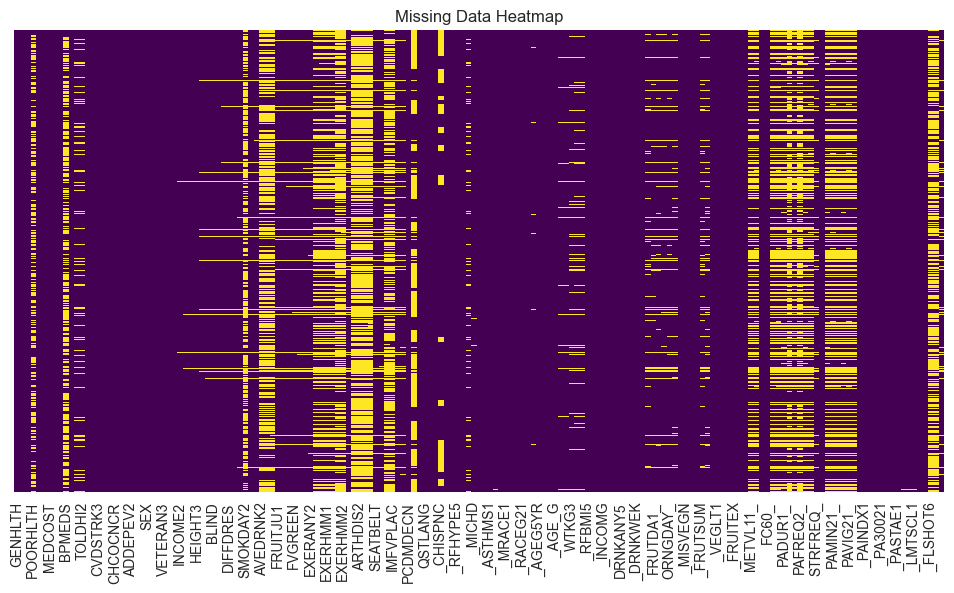

In [110]:
# Missing map 
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()


**1.High Missing Group - Rate > 50% (18 Columns)**

This group includes variables with a very high missing rate, indicating a need for extreme caution when using them or requiring sophisticated missing data handling methods.
- Mental Health/Function: Variables related to joint pain/arthritis (JOINPAIN - 69.7%, ARTHSOCL - 69.1%, ARTHDIS2 - 69.1%, LMTJOIN3 - 69.0%) and transgender identity (TRNSGNDR - 62.2%) have the highest missing rates.
- Vaccination: Calculated variables for influenza and pneumococcal vaccination for people 65 years and older (_FLSHOT6 - 64.2%, _PNEUMO2 - 64.2%) are also missing over 64%.
- Behavior/Health: Detailed information on alcohol consumption (MAXDRNKS, DRNK3GE5, AVEDRNK2 - about 52-52.4%) and smoking frequency (SMOKDAY2 - 58.3%) have high missing rates.
- Physical Activity (Secondary): Detailed variables on secondary physical activity (PADUR2_, PAFREQ2_, EXERHMM2, EXEROFT2) are missing from 55.4% to 56.4%.

**2. Medium Missing Group - Rate 10% − 50% (24 Columns)**

This group mainly focuses on detailed information about physical activity and some health indicators.
- General Health: The variable POORHLTH (Number of days poor health affected activity) has a missing rate near the high threshold (48.6%).
- Physical Activity (Detailed): Most detailed variables related to total minutes, intensity, and type of physical activity (both primary and secondary) are missing approximately 33% - 37%. Example: PAMIN21_ (36.4%), - - PAVIG21_ (35.8%), PA1MIN_ (34.5%).
- Screening: Variables concerning cholesterol checks (CHOLCHK, _RFCHOL, TOLDHI2) are missing about 13.4%.
- Diet: Total vegetable consumption (_VEGESUM - 11.6%) has a lower missing rate within this group.
- Ethnicity: The calculated variable for Hispanic origin of children (_CHISPNC) is missing 27.6%.

**3. Low Missing Group - Rate ≤ 10% (58 Columns)**

This group contains most of the important variables regarding demographics, general health status, and basic behaviors.
- Demographics & Basic: Variables like interview language (QSTLANG), chronic disease status (DIABETE3, BPHIGH4, HAVARTH3, CHCSCNCR), total physically unhealthy days (PHYSHLTH), and general health (GENHLTH) have 0.0% missing rates.
- Body Measurement: Height (HTIN4 - 3.9%, HEIGHT3 - 1.3%) and Weight (WTKG3 - 7.0%, WEIGHT2 - 1.2%) have very low missing rates. BMI (_BMI5, _BMI5CAT) is missing 8.2%.
- Basic Behavior: Behaviors like seatbelt use (SEATBELT - 9.2%), leisure-time exercise (EXERANY2 - 8.0%), having smoked 100 cigarettes or more (SMOKE100 - 3.2%), and alcohol use (ALCDAY5 - 3.6%) have low missing rates.
- Screening & Vaccination: Variables for HIV screening (HIVTST6 - 9.8%) and flu/pneumococcal vaccination (FLUSHOT6 - 9.4%, PNEUVAC3 - 9.5%) have missing rates under 10%.
- Disability: Questions about difficulty in activities (BLIND, DIFFWALK, DIFFDRES, DECIDE) are all missing under 3.0%.

## **4. Feature Analysis**

### 4.1. Target variable

In [111]:
target = "_MICHD"

In [112]:
# Number of missing values in target
missing_target = df[target].isnull().sum()
print(f"Missing values in target '{target}': {missing_target} ({(missing_target / len(df)) * 100:.2f}%)")

Missing values in target '_MICHD': 3942 (0.89%)


In [113]:
df[target].value_counts()

_MICHD
2.0    398881
1.0     38633
Name: count, dtype: int64

Number of people with cardiovascular disease: 38,633
Number of people without cardiovascular disease: 398,881
Total respondents: 441,456
Prevalence of reported CHD/MI: 8.75%


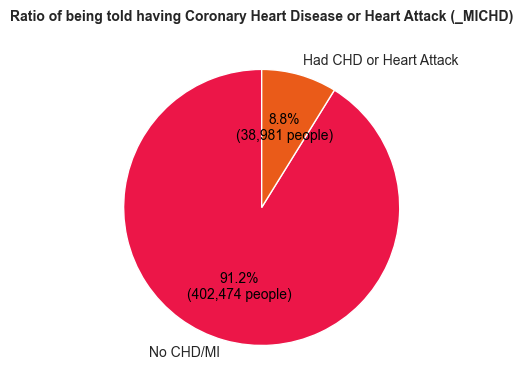

In [114]:
n_total = len(df[target])

# Counts
count_yes = (df[target] == 1).sum()
count_no  = (df[target] == 2).sum()
prevalence = count_yes / n_total * 100

print(f"Number of people with cardiovascular disease: {count_yes:,}")
print(f"Number of people without cardiovascular disease: {count_no:,}")
print(f"Total respondents: {n_total:,}")
print(f"Prevalence of reported CHD/MI: {prevalence:.2f}%")


plt.figure(figsize=(8, 4))
sns.set_style("white")

colors = ["#EC1648", "#EA5B19"] 

wedges, texts, autotexts = plt.pie(
    [count_no, count_yes],
    labels=['No CHD/MI', 'Had CHD or Heart Attack'],
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100 * n_total):,} people)',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

# Make percentage bold and dark
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)

plt.title("Ratio of being told having Coronary Heart Disease or Heart Attack (_MICHD)", 
          fontsize=10, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

**Imbalance Interpretation**
- The dataset shows a severe class imbalance, with only about ~8.8% of respondents reporting a Coronary Heart Disease or Heart Attack (`_MICHD = Yes`).
- This imbalance increases the risk that machine learning models will become biased toward predicting the majority class ("No").  
- In this context, accuracy is not a reliable metric, since even a naive model that always predicts "No" would achieve about ~91.2% accuracy.  

### 4.2. Categorical features

In [121]:
# Number of unique values in categorical features
print(f'Number of categorical features: {len(categorical_vars)}')
print("Number of unique values in categorical features:")

for col in categorical_vars:
    if col in brfss_data_dict.index:
        desc = brfss_data_dict.loc[col, "Description"]
    else:
        desc = "(no description)"
   
    print(f'{col} ({desc}): {df[col].nunique()}')

Number of categorical features: 108
Number of unique values in categorical features:
_TOTINDA (Leisure-time PA (calc)): 3
QLACTLM2 (Limited in activities due to health problems): 4
_RFDRHV5 (Heavy drinking (calc)): 3
_RFSMOK3 (Current smoking (calc)): 3
_PA300R2 (≥300 min/week PA): 4
_HCVU651 (Health care coverage age 18-64 (calc)): 3
JOINPAIN (Average joint pain past 30 days (0-10)): 13
DIFFDRES (Difficulty dressing/bathing): 4
DECIDE (Difficulty concentrating/remembering): 4
LMTJOIN3 (Limited due to joint symptoms (arthritis)): 4
_RFHYPE5 (Adults ever told high BP (calc)): 3
_LMTWRK1 (Arthritis limits work (calc)): 4
_PRACE1 (Preferred race): 10
_LMTACT1 (Arthritis limits activities (calc)): 4
HLTHPLN1 (Have any health care coverage): 4
USEEQUIP (Needs special equipment): 4
CHOLCHK (Time since last cholesterol check): 6
_RFBMI5 (Overweight/obese (calc)): 3
ASTHMA3 (Ever told you had asthma): 4
_AGE65YR (Age 65+ (calc)): 3
DRNKANY5 (Any alcohol past 30 days (calc)): 4
_RFSEAT3 (Always

### 4.2. Numerical Features

In [122]:
# Number of numeric features
print(f'Number of numeric features: {len(numeric_vars)}')

# Descriptive statistics for numeric features
num_summary = df[numeric_vars].describe().T
num_summary['missing_%'] = df[numeric_vars].isna().mean() * 100
num_summary['skewness'] = df[numeric_vars].skew()
num_summary['kurtosis'] = df[numeric_vars].kurt()
num_summary['unique'] = df[numeric_vars].nunique()
num_summary = num_summary[['count', 'unique', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis', 'missing_%']]
num_summary.round(2)

Number of numeric features: 56


,count,unique,mean,std,min,25%,50%,75%,max,skewness,kurtosis,missing_%
PHYSHLTH,441455.0,33,60.66,37.06,1.0,15.0,88.0,88.0,99.0,-0.68,-1.42,0.00
MENTHLTH,441456.0,33,64.68,35.84,1.0,28.0,88.0,88.0,99.0,-0.94,-1.03,0.00
POORHLTH,226964.0,33,55.77,38.07,1.0,10.0,88.0,88.0,99.0,-0.40,-1.73,48.59
CHILDREN,441451.0,26,65.91,37.71,1.0,4.0,88.0,88.0,99.0,-1.11,-0.77,0.00
WEIGHT2,436141.0,573,733.20,2197.38,50.0,149.0,175.0,210.0,9999.0,3.75,12.26,1.20
HEIGHT3,435545.0,151,742.18,1380.50,200.0,504.0,507.0,510.0,9999.0,6.07,35.29,1.34
ALCDAY5,425525.0,40,536.03,355.88,101.0,202.0,777.0,888.0,999.0,-0.04,-1.95,3.61
AVEDRNK2,210838.0,50,3.49,10.56,1.0,1.0,2.0,2.0,99.0,7.21,52.51,52.24
DRNK3GE5,210420.0,44,67.78,35.87,1.0,77.0,88.0,88.0,99.0,-1.23,-0.46,52.34
MAXDRNKS,210017.0,62,5.61,13.98,1.0,1.0,2.0,4.0,99.0,5.10,25.52,52.43


The large number of numeric variables (56 variables in this case) is a challenge that causes a lot of difficulties in visualization and overall analysis.
- Plotting or checking the distribution for each variable becomes infeasible and inefficient, leading to the risk of missing important variables or misunderstanding data trends.
- The ability to identify outliers, missing values ​​or relationships between variables and target variables becomes more complicated, making it difficult to draw raw insights.
- Raw data contains many variables leading to information noise, directly using all variables for modeling or analysis without going through the selection/feature engineering step can cause unintuitive results, difficult to interpret and difficult to convey insights

In [124]:
# Checking for outliers in numeric features using IQR method
outlier_report = {}
for col in numeric_vars:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = outliers.shape[0]
    outlier_percent = (outlier_count / len(df)) * 100
    
    outlier_report[col] = {
        'outlier_count': outlier_count,
        'outlier_percent': outlier_percent
    }

outlier_df = pd.DataFrame.from_dict(outlier_report, orient='index', columns=['outlier_count', 'outlier_percent'])
outlier_df = outlier_df.sort_values('outlier_percent', ascending=False)
outlier_df

,outlier_count,outlier_percent
HEIGHT3,82032,18.582146
FVBEANS,78209,17.716148
FVORANG,66551,15.075342
_DRNKWEK,60498,13.704197
PAVIG21_,59864,13.560581
DROCDY3_,55848,12.650864
DRNK3GE5,50601,11.462297
PADUR1_,43861,9.935532
FVGREEN,38056,8.620565
WEIGHT2,32048,7.259614


In [127]:
# Top 10 numeric features with highest correlation with target
correlations = {}
for col in numeric_vars:   
    if col == target:
        continue
    valid_data = df[[col, target]].dropna()
    if len(valid_data) < 2:
        continue
    corr = valid_data[col].corr(valid_data[target])
    correlations[col] = corr

correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
correlations = pd.DataFrame(correlations, columns=['Feature', 'Correlation'])
correlations.head(10)

,Feature,Correlation
0,_AGE80,-0.225152
1,CHILDREN,-0.114522
2,PHYSHLTH,0.097020
3,ALCDAY5,-0.087234
4,STRENGTH,-0.068734
5,PA1VIGM_,-0.062391
6,POORHLTH,0.057177
7,_BMI5,-0.053899
8,PAVIG11_,-0.052940
9,WTKG3,-0.052838


C:\Users\pc\AppData\Local\Temp\ipykernel_7564\2323000393.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=palette)


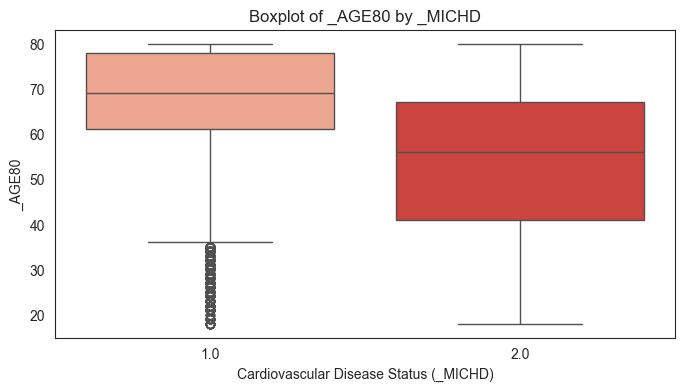

C:\Users\pc\AppData\Local\Temp\ipykernel_7564\2323000393.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=palette)


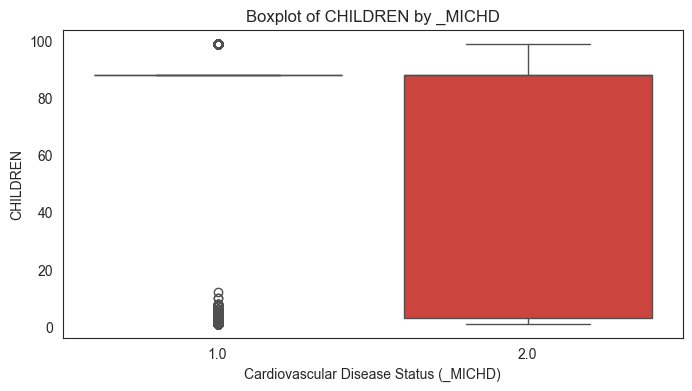

C:\Users\pc\AppData\Local\Temp\ipykernel_7564\2323000393.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=palette)


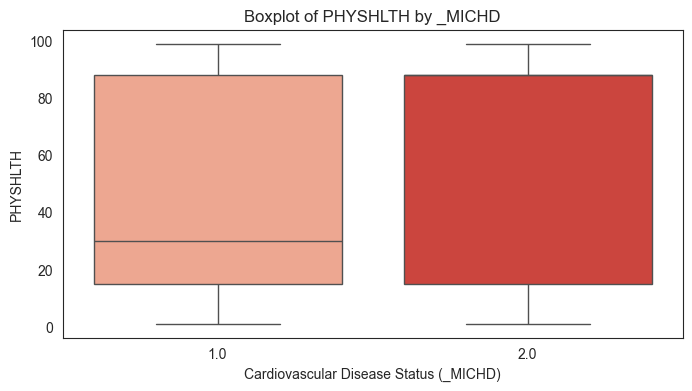

C:\Users\pc\AppData\Local\Temp\ipykernel_7564\2323000393.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=palette)


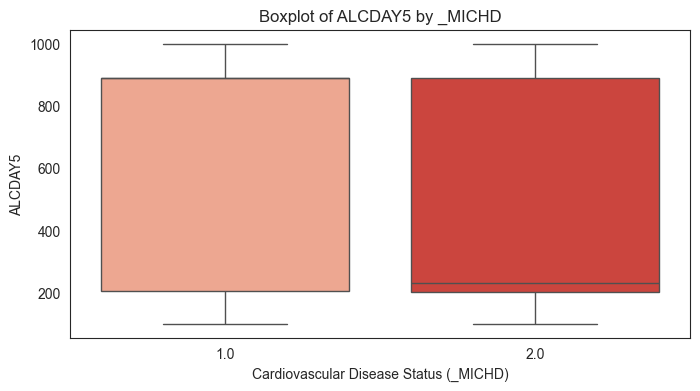

C:\Users\pc\AppData\Local\Temp\ipykernel_7564\2323000393.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=palette)


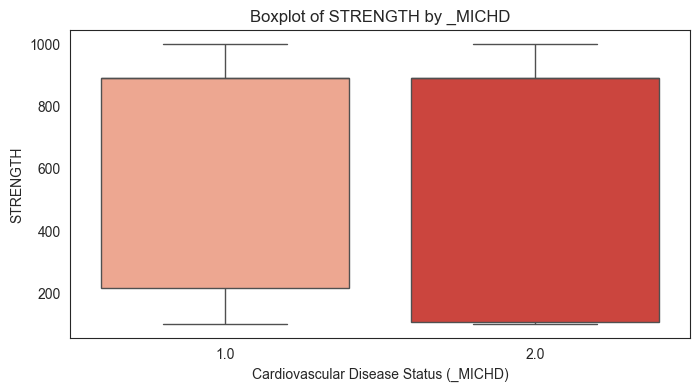

C:\Users\pc\AppData\Local\Temp\ipykernel_7564\2323000393.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=palette)


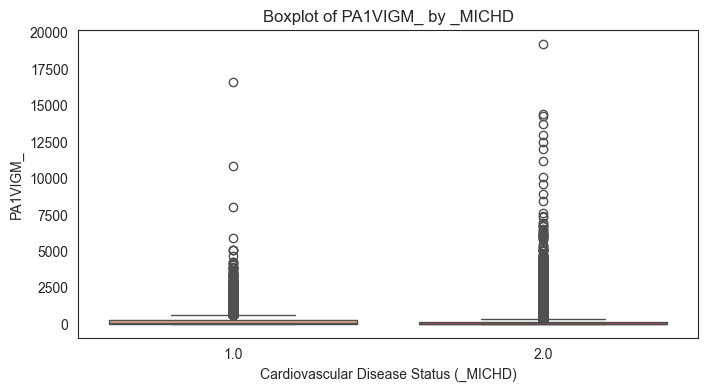

C:\Users\pc\AppData\Local\Temp\ipykernel_7564\2323000393.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=palette)


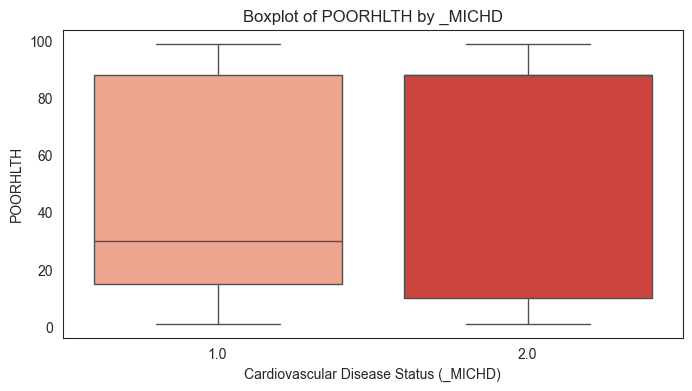

C:\Users\pc\AppData\Local\Temp\ipykernel_7564\2323000393.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=palette)


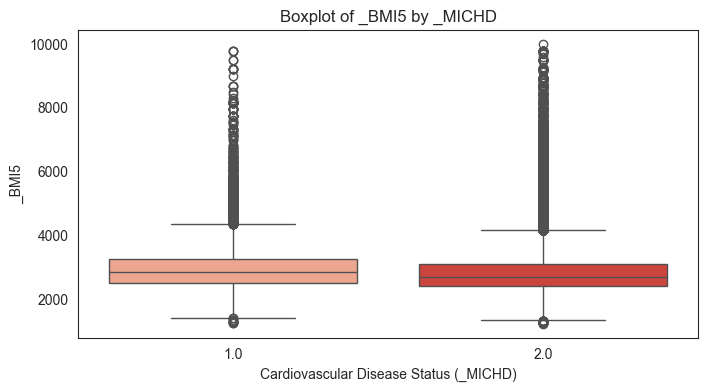

C:\Users\pc\AppData\Local\Temp\ipykernel_7564\2323000393.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=palette)


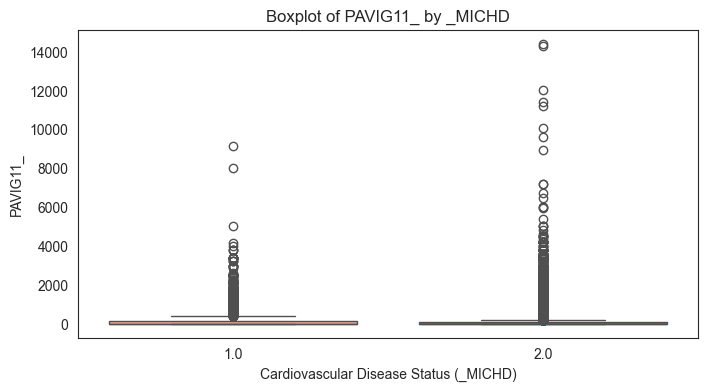

C:\Users\pc\AppData\Local\Temp\ipykernel_7564\2323000393.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=col, data=df, palette=palette)


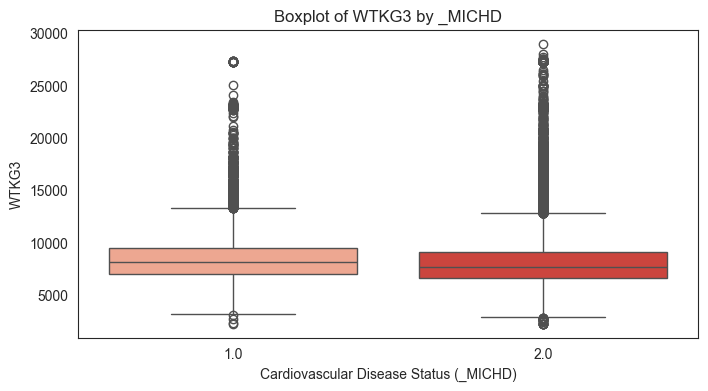

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

top_features = correlations['Feature'].head(10).tolist()
for col in top_features:
    plt.figure(figsize=(8, 4))
    
    
    palette = sns.color_palette("Reds", n_colors=df[target].nunique())
    
    
    sns.boxplot(x=target, y=col, data=df, palette=palette)
    
    plt.title(f'Boxplot of {col} by {target}')
    plt.xlabel('Cardiovascular Disease Status (_MICHD)')
    plt.ylabel(col)
    plt.show()


### 4.3. Boolean features

In [119]:

# Boolean features summary with description
target = 'MICHD'
for col in boolean_vars:
    if col == target:
        continue  

    n_unique = df[col].nunique()
    counts = df[col].value_counts(dropna=False)
    
    description = brfss_data_dict.loc[col, "Description"] if col in brfss_data_dict.index else "No description available"
    
    print(f"\n{col} ({n_unique} unique values)")
    print(f"Description: {description}")
    print(counts)





_DRDXAR1 (2 unique values)
Description: Diagnosed arthritis (calc)
_DRDXAR1
2.0    290621
1.0    148036
NaN      2799
Name: count, dtype: int64

_MICHD (2 unique values)
Description: Reported MI or CHD (calc)
_MICHD
2.0    398881
1.0     38633
NaN      3942
Name: count, dtype: int64

_FRT16 (2 unique values)
Description: Fruit >16/day flag
_FRT16
1.000000e+00    441364
5.400000e-79        92
Name: count, dtype: int64

_VEG23 (2 unique values)
Description: Veg >23/day flag
_VEG23
1.000000e+00    441409
5.400000e-79        47
Name: count, dtype: int64

SEX (2 unique values)
Description: Sex
SEX
2    254518
1    186938
Name: count, dtype: int64

_FRTRESP (2 unique values)
Description: Fruit response flag
_FRTRESP
1.000000e+00    397745
5.400000e-79     43711
Name: count, dtype: int64

_VEGRESP (2 unique values)
Description: Vegetable response flag
_VEGRESP
1.000000e+00    390339
5.400000e-79     51117
Name: count, dtype: int64


**Summary for boolean features:**
| Feature  | Description                | Meaning / Interpretation                                                                   | Values |
| -------- | -------------------------- | ------------------------------------------------------------------------------------------ | ------ |
| SEX      | Sex                        | 1 = Male, 2 = Female                                                                       | 1, 2   |
| _MICHD   | Reported MI or CHD (calc)  | 1 = Has reported myocardial infarction or coronary heart disease, 2 = No history           | 1, 2   |
| _DRDXAR1 | Diagnosed arthritis (calc) | 1 = Has arthritis, 2 = No arthritis                                                        | 1, 2   |
| _FRTRESP | Fruit response flag        | 1 = Responded to fruit intake questions, very small value (≈5.4e-79) = Did not respond     | 1, ≈0  |
| _VEGRES  | Vegetable response flag    | 1 = Responded to vegetable intake questions, very small value (≈5.4e-79) = Did not respond | 1, ≈0  |
| _FRT16   | Fruit >16/day flag         | 1 = Consumes ≥1 fruit per day, very small value (≈5.4e-79) = Does not meet                 | 1, ≈0  |
| _VEG23   | Veg >23/day flag           | 1 = Consumes ≥1 vegetable per day, very small value (≈5.4e-79) = Does not meet             | 1, ≈0  |


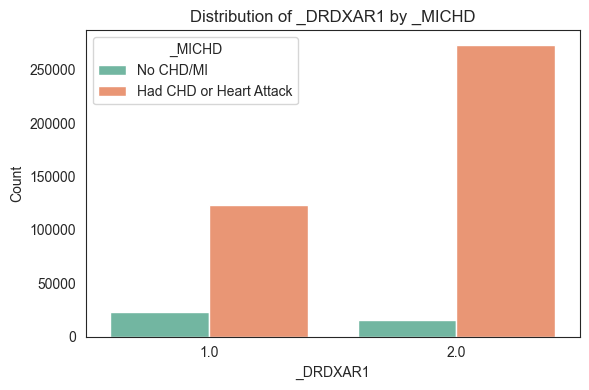

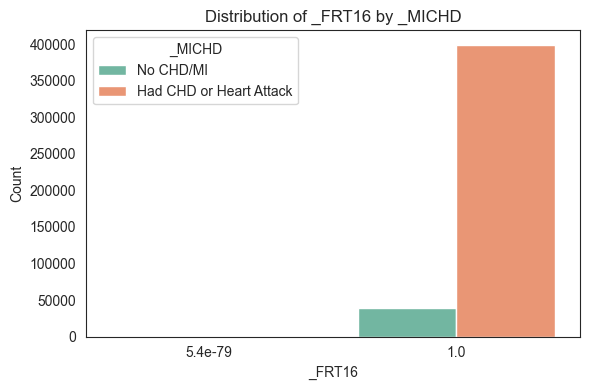

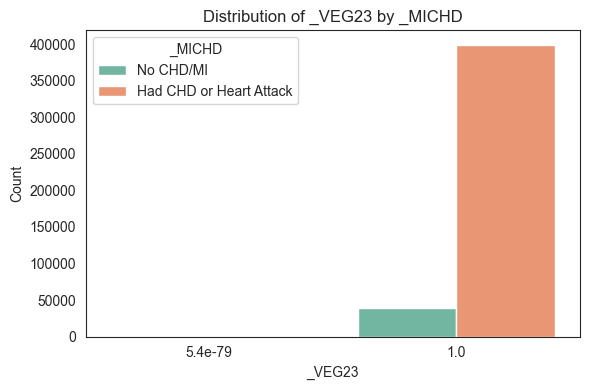

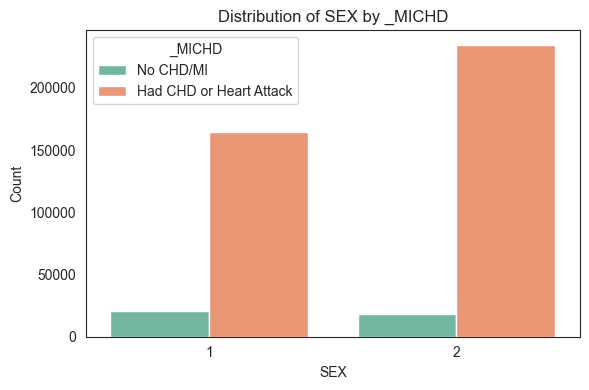

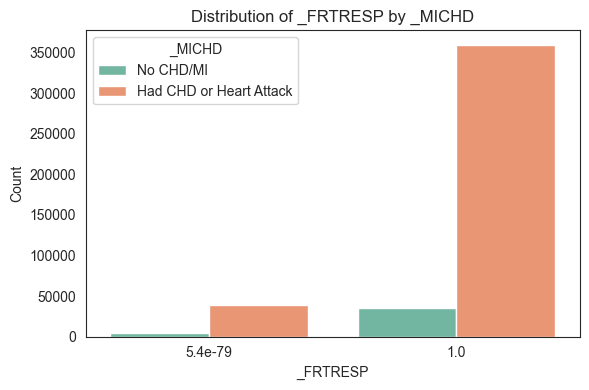

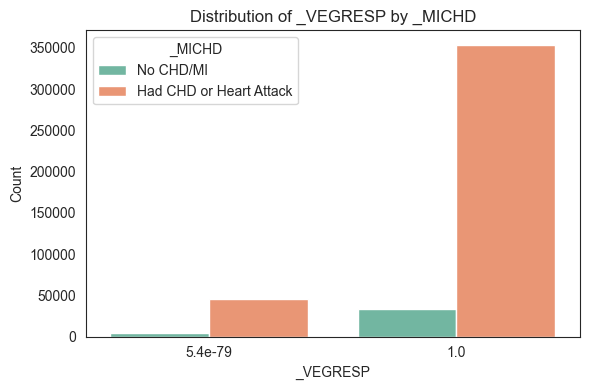

In [120]:
# Plots of tagert variable against boolean features
target = '_MICHD'  
for col in boolean_vars:
    if col == target:
        continue  

    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue=target, data=df, palette='Set2')
    plt.title(f"Distribution of {col} by {target}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title=target, labels=['No CHD/MI', 'Had CHD or Heart Attack'])
    plt.tight_layout()
    plt.show()